In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams, conv #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [97]:
qb = 2 # qubit to operate on

# Conversion factors from standard SI units
us = 1e6
ns = 1e9
GHz = 1e-9

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 2 has a 
  - T1 time of 66.12702003391938 microseconds
  - T2 time of 79.76565061892423 microseconds
  - U2 gate error of 0.00036991995088111725
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.618213493327425 GHz


In [127]:
shots = 1024 # determines clarity of results

period = 850 # Rabi oscillation period
cycles = [5, 20, 40, 80, 160] # number of rabi cycles to perform for each oscillation
cycles_to_plot = 7 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const_arr = [0, 23.66156363955276, 60.71437458094607]
predict_power_arr =  [0, -0.9940037912357684, -0.9478600149564859]
predict_const = predict_const_arr[qb]
predict_power = predict_power_arr[qb]

sig_predict_const_arr = [0, 5.35893609525708, 11.45245806804462 ]
sig_predict_power_arr = [0, -0.9654741107610489, -0.9847146457687506]
sig_predict_const = sig_predict_const_arr[qb]
sig_predict_power = sig_predict_power_arr[qb]

In [128]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = period // 64 # density of datapoints in a cycle capture
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        64)
    
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = get_closest_multiple_of_16(drive_times[i] - (6 * drive_sigma))

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
                    
        # add end cap
        this_schedule += Play(end_cap, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

In [129]:
drive_amp

0.06177692703623234

In [130]:
len(experiments)

467

In [131]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [84]:
# job = backend.retrieve_job('5efe5373160c520019169510')

In [141]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [142]:
qb_rabi_data = []
all_params = []
all_fits = []
all_convs = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p, c = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 5])
    all_params.append(p)
    all_convs.append(c)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    
    single_period_data = np.array(single_period_data)
    # residual sum of squares
    ss_res = np.sum((single_period_data - np.array(y_fit)) ** 2)
    # total sum of squares
    ss_tot = np.sum((single_period_data - np.mean(single_period_data)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    
    all_fits.append(y_fit)

0.9975338671923096
0.9978694332555875
0.9971899303106947
0.9933280911559412
0.9868432237153735


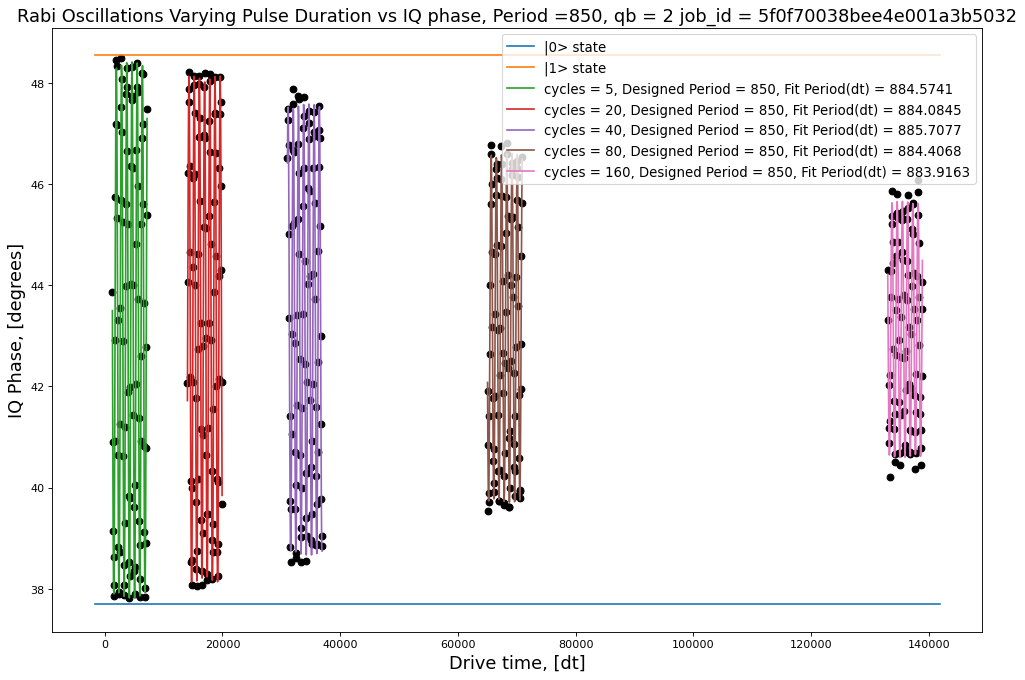

In [143]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

start_plot_time = (period*cycles[0])-(len(data_times[0]) * 64)
end_plot_time = (period*cycles[-1])+(len(data_times[-1]) * 64)
plt.plot([start_plot_time, end_plot_time],2*[state0],label="|0> state")
plt.plot([start_plot_time, end_plot_time],2*[state1],label="|1> state")

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)
for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb) + " job_id = " + str(job.job_id()), fontsize=16)
# plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase", fontsize=16)
plt.show()

In [144]:
sigma = []
for i in all_convs:
    print(i)
    perr = np.sqrt(np.diag(i))
    print(perr)
    sigma.append(perr[0])
    print()

[[ 7.79842519e-04 -2.58182252e-05 -2.27421174e-06 -2.67373420e-06]
 [-2.58182252e-05  3.85629642e-04  5.24979458e-04 -1.57204889e-05]
 [-2.27421174e-06  5.24979458e-04  1.37284551e-01 -4.67782301e-03]
 [-2.67373420e-06 -1.57204889e-05 -4.67782301e-03  1.86243486e-04]]
[0.02792566 0.01963746 0.3705193  0.01364711]

[[ 5.99344861e-04 -2.08694929e-05  4.25753261e-06  6.72961895e-07]
 [-2.08694929e-05  2.94820326e-04 -4.52322301e-04  6.08760711e-05]
 [ 4.25753261e-06 -4.52322301e-04  1.15719697e-01 -1.58078969e-02]
 [ 6.72961895e-07  6.08760711e-05 -1.58078969e-02  2.18234004e-03]]
[0.02448152 0.01717033 0.34017598 0.04671552]

[[ 6.29207020e-04 -6.64535562e-06  6.88736995e-05 -1.68308081e-05]
 [-6.64535562e-06  3.21983178e-04 -1.68336394e-04  4.05832853e-05]
 [ 6.88736995e-05 -1.68336394e-04  1.82001051e-01 -4.95454853e-02]
 [-1.68308081e-05  4.05832853e-05 -4.95454853e-02  1.35206627e-02]]
[0.025084   0.01794389 0.42661581 0.11627838]

[[ 8.96911899e-04 -2.27135769e-05 -4.31765022e-05  1

In [145]:
for i in range(len(cycles)):
    print(f'{abs(np.array(all_params)[:,0][i])}')
print()
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')
print()
print(sigma)

5.297555321500954
4.998016940136478
4.457329829138424
3.446260902094111
2.531124689942748

10.68405641006428
10.16394762590864
9.357989447854798
7.274855924113304
5.880932456471193

[0.027925660590381596, 0.024481520809246076, 0.025083999283415787, 0.029948487423922303, 0.030979308699296354]


0.9943188683256019


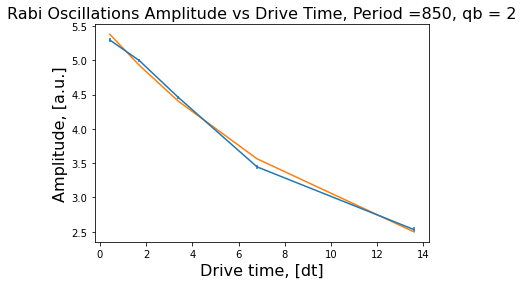

In [146]:
xvals = [(period*i)/10000 for i in cycles]
amps = abs(np.array(all_params)[:,0])
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, conv = curve_fit(func, xvals, amps, [4, 0.1, 1], sigma)
y_fit = [func(x, p[0], p[1], p[2]) for x in xvals]

amps = np.array(amps)
# residual sum of squares
ss_res = np.sum((amps - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((amps - np.mean(amps)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(xvals, amps, yerr=sigma)
plt.plot(xvals, y_fit)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Rabi Oscillations Amplitude vs Drive Time, Period =" + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [147]:
print(p)
print(f'{p[1]}')
print(f'{drive_amp}')
print(conv)

[4.2917517  0.09094847 1.25183438]
0.09094847238627826
0.06177692703623234
[[ 0.54906963 -0.02138068 -0.59519355]
 [-0.02138068  0.00092979  0.02411883]
 [-0.59519355  0.02411883  0.65718798]]


[0.052043045, 0.033930088, 0.025048032, 0.019793963, 0.016330365, 0.013879266, 0.01205548]
[0.09449181562433151, 0.044807452624331515, 0.030481553624331522, 0.026552136624331518, 0.02174849762433152, 0.02153489462433152, 0.02342985762433152]
[0.027926689742968105, 0.005044993369668587, 0.005443634190501783, 0.005253808447212365, 0.002924295677594863, 0.001037220497290716, 0.0013148664228734416]
0.6622031835016984


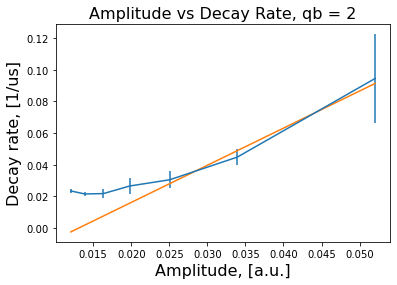

In [149]:
more_conv = [
[[ 0.13422955, -0.00857689, -0.14547202],
 [-0.00857689,  0.0007799 ,  0.01100414],
 [-0.14547202,  0.01100414,  0.17305023]],
[[ 3.19932976e-02, -8.33412296e-04, -3.46149219e-02],
 [-8.33412296e-04,  2.54519581e-05,  9.56854261e-04],
 [-3.46149219e-02,  9.56854261e-04,  3.85500093e-02]],
[[ 7.18769900e-02, -1.33548606e-03, -7.82805982e-02],
 [-1.33548606e-03,  2.96331532e-05,  1.55919148e-03],
 [-7.82805982e-02,  1.55919148e-03,  8.82732809e-02]],
[[ 5.77040467e-02, -1.09315960e-03, -6.33432335e-02],
 [-1.09315960e-03,  2.76025032e-05,  1.36863844e-03],
 [-6.33432335e-02,  1.36863844e-03,  7.47263644e-02]],
[[ 2.58051311e-02, -3.73630977e-04, -2.80436572e-02],
 [-3.73630977e-04,  8.55150521e-06,  5.26244786e-04],
 [-2.80436572e-02,  5.26244786e-04,  3.58587237e-02]],
[[ 3.11349634e-03, -3.97269869e-05, -3.13787892e-03],
 [-3.97269869e-05,  1.07582636e-06,  6.20278207e-05],
 [-3.13787892e-03,  6.20278207e-05,  4.15183953e-03]],
[[ 3.52597523e-03, -2.61885025e-05, -2.38956319e-03],
 [-2.61885025e-05,  1.72887371e-06,  7.41918478e-05],
 [-2.38956319e-03,  7.41918478e-05,  3.96303022e-03]]
]

gammas_tilde = [0.109614227, 0.059929864, 0.045603965, 0.041674548, 0.036870909, 0.036657306, 0.038552269]
amplitudes = [0.052043045, 0.033930088, 0.025048032, 0.019793963, 0.016330365, 0.013879266, 0.01205548]

more_sigma = [np.sqrt(np.diag(i))[1] for i in more_conv]
gammas = [g - 1/(props.t1(qb) * us) for g in gammas_tilde]
print(amplitudes)
print(gammas)
print(more_sigma)


def func(x):
    return  2.3461328258578 * x  -0.0307360713568988

# p, pcov = curve_fit(func, amplitudes, gammas, [2, 0])
y_fit = [func(x) for x in amplitudes]

gammas = np.array(gammas)
# residual sum of squares
ss_res = np.sum((gammas - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((gammas - np.mean(gammas)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(amplitudes, gammas, yerr=more_sigma)
plt.plot(amplitudes, y_fit)
plt.ylabel('Decay rate, [1/us]', fontsize=16)
plt.xlabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Amplitude vs Decay Rate, qb = " + str(qb), fontsize=16)
plt.show()

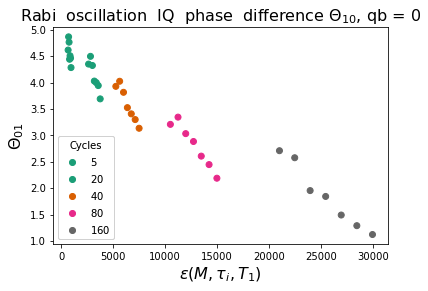

[-1.10345038e-04  4.46056080e+00]
[[ 3.13898072e-11 -3.04636384e-07]
 [-3.04636384e-07  5.48124951e-03]]


In [153]:
errors = [656.1543982, 2624.617593, 5249.235185, 10498.47037, 20996.94074, 702.0343734, 2808.137494, 5616.274987, 11232.54997, 22465.09995, 748.4202796, 2993.681119, 5987.362237, 11974.72447, 23949.44895, 795.0827536, 3180.331014, 6360.662029, 12721.32406, 25442.64811, 841.9198522, 3367.679409, 6735.358817, 13470.71763, 26941.43527, 888.8772853, 3555.509141, 7111.018283, 14222.03657, 28444.07313, 935.9226903, 3743.690761, 7487.381523, 14974.76305, 29949.52609]
cycles = [5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160, 5, 20, 40, 80, 160]
amps = [4.617710739, 4.351782188, 3.929665083, 3.209085447, 2.709938099, 4.867971959, 4.498334917, 4.026202528, 3.346237366, 2.576509753, 4.766859053, 4.32508765, 3.816748538, 3.03355349, 1.953926147, 4.443016216, 4.029763913, 3.526323838, 2.884357198, 1.84297663, 4.50958548, 3.999831676, 3.408507583, 2.607163711, 1.490607971, 4.463362893, 3.944515979, 3.300074297, 2.446771991, 1.289007061, 4.28538436, 3.692278193, 3.135415908, 2.188505079, 1.12132314] 

def func(x, m, b):
    return m * x + b
p, pcov = curve_fit(func, errors, amps, [0, 0])
y_fit = [func(x, p[0], p[1]) for x in errors]

fig, ax = plt.subplots()
scatter = ax.scatter(errors, amps, c=cycles, cmap="Dark2")
# plt.plot(errors, y_fit, color='black')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cycles")
ax.add_artist(legend1)
plt.ylabel('$\Theta_{01}$', fontsize=16)
plt.xlabel('$\epsilon(M, \\tau_i, T_1)$', fontsize=16)
plt.title("Rabi  oscillation  IQ  phase  difference $\Theta_{10}$, qb = 0", fontsize=16)
plt.show()
print(p)
print(pcov)